In [1]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy import ndimage
# from scipy.optimize import curve_fit
from scipy.optimize import minimize
# from scipy.stats import median_absolute_deviation
import xarray as xr

import debrisglobal.globaldebris_input as debris_prms
import class_climate_debris

In [2]:
data_source = 'regional'
# data_source = 'individual_glaciers'

# rois = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']
rois = ['11','12','13','14','15','18']
# rois = ['13','14','15']

area_chg_rate_dict = {'01':-0.42,
                      '18':-0.69}

# output_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/'
# output_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/_retreat_removed/'
output_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/_bnds/'

mf_cn = 'mf_ts_mean_bndhigh'
if mf_cn == 'mf_ts_mean_bndlow':
    mf_str = 'bndlow_'
elif mf_cn == 'mf_ts_mean_bndhigh':
    mf_str = 'bndhigh_'
else:
    mf_str = ''

if data_source in ['individual_glaciers']:
    mb_shean_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/' + 
                       'hma_mb_20190215_0815_std+mean_all_filled_bolch.csv')
    mb_shean_df = pd.read_csv(mb_shean_fullfn)
    mb_shean_df['RGIId'] = ['RGI60-' + str(int(x)) + '.' + str(int(np.round((x - int(x)) * 1e5,0))).zfill(5) 
                            for x in mb_shean_df.RGIId.values]
elif data_source in ['regional']:
    roi_mbobs_dict = {'01': [-0.70, 0.18],
                      '02': [-0.50, 0.91],
                      '03': [-0.38, 0.80],
                      '04': [-0.80, 0.22],
                      '05': [-0.57, 0.20],
                      '06': [-0.69, 0.26],
                      '07': [-0.27, 0.17],
                      '08': [-0.66, 0.27],
                      '09': [-0.30, 0.27],
                      '10': [-0.40, 0.31],
                      '11': [-0.91, 0.70],
                      '12': [-0.88, 0.57],
                      '13': [-0.19, 0.15],
                      '14': [-0.11, 0.15],
                      '15': [-0.44, 0.15],
                      '16': [-0.59, 0.58],
                      '17': [-0.86, 0.17],
                      '18': [-0.59, 1.14]}

2888 glaciers in region 11 are included in this model run: ['00001', '00002', '00003', '00004', '00005', '00006', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00018', '00019', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00030', '00031', '00034', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00046', '00047', '00048', '00049', '00050', '00051', '00053', '00054', '00055', '00056', '00060', '00062', '00063', '00065', '00066', '00067', '00068'] and more
This study is focusing on 2888 glaciers in region [11]
ROI 11 has 2888 dc glaciers
All glaciers within region(s) 11 are included in this model run.
This study is focusing on 3927 glaciers in region [11]
1039 glaciers in region 11 are included in this model run: ['00007', '00015', '00016', '00017', '00020', '00029', '00032', '00033', '00035', '00036', '00044', '00045', '00052', '00057', '00058', '00059', '00061', '00064', '00069', '00071', '00076', '00087', '00093', '00097', '0

/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


All glaciers within region(s) 14 are included in this model run.
This study is focusing on 27988 glaciers in region [14]
22119 glaciers in region 14 are included in this model run: ['00001', '00002', '00003', '00004', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00019', '00021', '00022', '00023', '00024', '00025', '00027', '00030', '00031', '00034', '00035', '00037', '00038', '00039', '00040', '00041', '00042', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00058', '00059', '00060', '00061', '00062'] and more
This study is focusing on 22119 glaciers in region [14]
Debris-covered area only:
  mbclim (debris): -0.11 mwea
  mbclim (clean): -0.26 mwea
24.0%
76.0%
reg_mbclim_df area: 25406.514371
regional area: 33568.298
-0.10985685250040844 25406.514371 -0.11 8138.9839999999995
reg_mb_wdebris: -0.11
reg_mb_nodebris: -0.23 


5295 glaciers in region 15 are included i

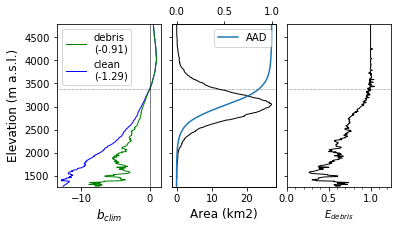

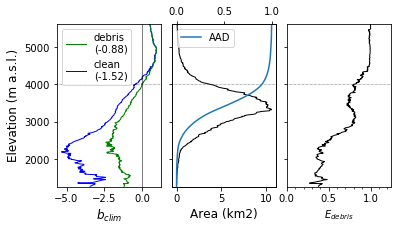

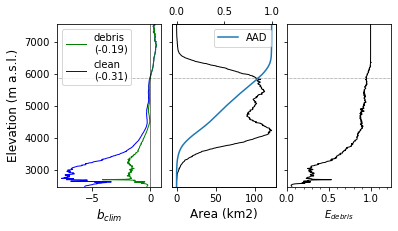

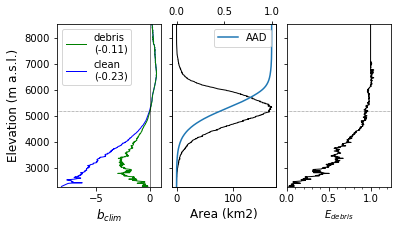

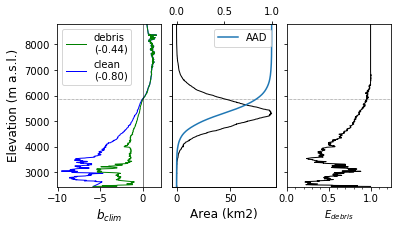

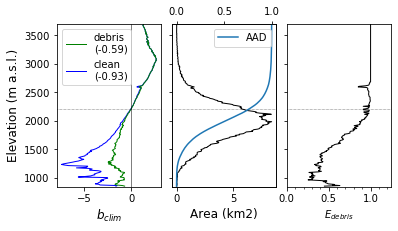

In [3]:
# ===== REGIONAL MBCLIM PLOTS ====================================================================================
# PyGEM HH2015 calibration with and without debris
reg_output_cns = ['roi', 'area_km2', 'mb_obs_mwea', 'mb_obs_mwea_std', 'mb_mod_mwea', 'mb_mod_mwea_clean']
reg_output_df = pd.DataFrame(np.zeros((len(rois),len(reg_output_cns))), columns=reg_output_cns)
for nroi, roi in enumerate(rois):
    
    output_fp_roi = output_fp + mf_str + data_source + '-mbclim/' + roi + '/'
    
    mbclim_fns = []
    for i in os.listdir(output_fp_roi):
        if i.endswith('_mbclim_data.csv'):
            mbclim_fns.append(i)
    
    mbclim_fns = sorted(mbclim_fns)
    rgiids_wdebris = ['RGI60-' + x.split('_')[0].split('.')[0].zfill(2) + '.' + x.split('_')[0].split('.')[1] 
                      for x in mbclim_fns]
    rgino_str_wdebris = [x.split('-')[1] for x in rgiids_wdebris]
    
    main_glac_rgi_wdebris = debris_prms.selectglaciersrgitable(glac_no=rgino_str_wdebris)
    main_glac_rgi_wdebris['mbclim_fn'] = mbclim_fns
    
    print('ROI', roi, 'has', len(rgiids_wdebris), 'dc glaciers')
    
    mbclim_df_all = None
    reg_dc_area = 0
    for nglac, mbclim_fn in enumerate(mbclim_fns):
        mbclim_df = pd.read_csv(output_fp_roi + main_glac_rgi_wdebris.loc[nglac,'mbclim_fn'])
        mbclim_df['elev'] = [int(np.round(x,0)) for x in mbclim_df.elev.values]
        
#         print(mbclim_fn, main_glac_rgi_wdebris.loc[nglac, 'rgino_str'])
#         print('  ', mbclim_df.area.sum(), main_glac_rgi_wdebris.loc[nglac, 'Area'])
        if mbclim_df_all is None:
            mbclim_df_all = mbclim_df
        else:
            mbclim_df_all = pd.concat([mbclim_df_all, mbclim_df], axis=0)
    mbclim_df_all.reset_index(inplace=True, drop=True)
    
    elev_min = mbclim_df_all.elev.min()
    elev_max = mbclim_df_all.elev.max()
    elev_bins_all = np.arange(elev_min, elev_max+5, 10)
    reg_mbclim_df = pd.DataFrame(np.zeros((len(elev_bins_all), len(mbclim_df.columns))), columns=mbclim_df.columns)
    for nelev, elev in enumerate(elev_bins_all):
        try:
            elev_idx = np.where(mbclim_df_all.elev.values == elev)[0]
        except:
            elev_idx = []
        
        if len(elev_idx) > 0:
            mbclim_df_all_subset = mbclim_df_all[mbclim_df_all.elev == elev]
            reg_subset_area = mbclim_df_all_subset.area.sum()
            reg_subset_mf = (mbclim_df_all_subset.mf * mbclim_df_all_subset.area).sum() / reg_subset_area
            reg_subset_mbclim_wdebris = ((mbclim_df_all_subset.mbclim_mwea_wdebris * mbclim_df_all_subset.area).sum() 
                                         / reg_subset_area)
            reg_subset_mbclim_nodebris = ((mbclim_df_all_subset.mbclim_mwea_nodebris * mbclim_df_all_subset.area).sum() 
                                          / reg_subset_area)
            reg_frontalablation = ((mbclim_df_all_subset.frontalablation * mbclim_df_all_subset.area).sum() 
                                   / reg_subset_area)
            reg_mbclim_df.loc[nelev,:] = [elev, reg_subset_area, reg_subset_mf, reg_subset_mbclim_wdebris, 
                                          reg_subset_mbclim_nodebris, reg_frontalablation]
            
    # ===== REGIONAL COMPUTATIONS ======
    reg_mbclim_wdebris_DC = (reg_mbclim_df.mbclim_mwea_wdebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()
    reg_mbclim_nodebris_DC = (reg_mbclim_df.mbclim_mwea_nodebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()

    main_glac_rgi_all = debris_prms.selectglaciersrgitable(rgi_regionsO1=[int(roi)], rgi_regionsO2='all',
                                                           rgi_glac_number='all')
    rgiids_all = list(main_glac_rgi_all.RGIId.values)
    rgiids_missing = set(rgiids_all) - set(rgiids_wdebris)
    rgino_str_missing = [x.split('-')[1] for x in rgiids_missing]
    main_glac_rgi_missing = debris_prms.selectglaciersrgitable(glac_no=rgino_str_missing)
    
    print('Debris-covered area only:')
    print('  mbclim (debris): ' + str(np.round(reg_mbclim_wdebris_DC,2)) + ' mwea')
    print('  mbclim (clean): ' + str(np.round(reg_mbclim_nodebris_DC,2)) + ' mwea')
    print(str(np.round(main_glac_rgi_missing.Area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print(str(np.round(reg_mbclim_df.area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print('reg_mbclim_df area:', reg_mbclim_df.area.sum())
    print('regional area:', main_glac_rgi_all.Area.sum())
    
    reg_mb_all = roi_mbobs_dict[roi][0]
    print(reg_mbclim_wdebris_DC, reg_mbclim_df.area.sum(), reg_mb_all, main_glac_rgi_missing.Area.sum())

    reg_mb_wdebris = ((reg_mbclim_wdebris_DC * reg_mbclim_df.area.sum() + 
                       reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                      / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))
    reg_mb_nodebris = ((reg_mbclim_nodebris_DC * reg_mbclim_df.area.sum() + 
                        reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                       / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))

    print('reg_mb_wdebris:', np.round(reg_mb_wdebris,2))
    print('reg_mb_nodebris:', np.round(reg_mb_nodebris,2),'\n\n')

            
    # ===== Plot regional curves ======
    # Only plot mass balance of bins with glacier (otherwise get streaks to 0 that aren't real)
    elev_bins = reg_mbclim_df.elev.values
    bins_area = reg_mbclim_df.area.values
    glacier_debrismf = reg_mbclim_df.mf.values
    glac_bin_massbalclim_annual_mean_wdebris = reg_mbclim_df.mbclim_mwea_wdebris.values
    glac_bin_massbalclim_annual_mean_nodebris = reg_mbclim_df.mbclim_mwea_nodebris.values
    
    bins_idx = np.where(bins_area > 0)[0]
    # ELA for each plot
    ela = elev_bins[np.abs(glac_bin_massbalclim_annual_mean_wdebris[bins_idx]).argmin()]
    
    fig, ax = plt.subplots(1, 3, squeeze=False, sharex=False, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0})
    
    mbclim_wdebris_4fig = "{:.2f}".format(reg_mb_wdebris)
    mbclim_nodebris_4fig = "{:.2f}".format(reg_mb_nodebris)
    bins_idx = np.where(bins_area > 0)[0]
    # Mass balance gradients
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_wdebris[bins_idx], elev_bins[bins_idx], 
                 color='g', linewidth=1, zorder=2, label='debris\n(' + mbclim_wdebris_4fig + ')')
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_nodebris[bins_idx], elev_bins[bins_idx], 
                 color='b', linewidth=1, zorder=1, label='clean\n(' + mbclim_nodebris_4fig + ')')
    ax[0,0].axvline(x=0, color='k', linewidth=0.5)
    ax[0,0].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,0].set_xlabel('$b_{clim}$', size=12)
    ax[0,0].set_ylabel('Elevation (m a.s.l.)', size=12)
    ax[0,0].set_ylim(elev_bins.min() - 10, elev_bins.max() + 10)
    ax[0,0].legend()

    # Glacier hypsometry
    ax[0,1].plot(bins_area[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,1].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,1].set_xlabel('Area (km2)', size=12)
    
    ax2 = ax[0,1].twiny()
    bins_area_cumsum = np.cumsum(bins_area)
    ax2.plot(bins_area_cumsum / bins_area.sum(), elev_bins, label='AAD')
    ax2.legend()

    # Debris thickness
    ax[0,2].plot(glacier_debrismf[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,2].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,2].set_xlabel('$E_{debris}$')
    ax[0,2].set_xlim(0,1.25)
    ax[0,2].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0,2].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  

#     # Tick parameters
#     #ax[0,0].yaxis.set_ticks_position('both')
#     ax[0,0].tick_params(axis='both', which='major', labelsize=10, direction='inout')
#     ax[0,0].tick_params(axis='both', which='minor', labelsize=8, direction='in') 
    # Save plot
    fig.set_size_inches(6, 3)
    fig_fp = output_fp + 'debris_figs/' + mf_str + data_source + '/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig_fn = roi + '_mbgrad_debris.png'
    fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300, transparent=True)

In [6]:
# ===== REGIONAL MB DIFFERENCE (key: includes frontal ablation) =====================================================
apply_min_perc = False
# PyGEM HH2015 calibration with and without debris
reg_output_cns = ['roi', 'area_km2', 'mb_obs_mwea', 'mb_obs_mwea_std', 'mb_mod_mwea', 'mb_mod_mwea_clean']
reg_output_df = pd.DataFrame(np.zeros((len(rois),len(reg_output_cns))), columns=reg_output_cns)
for nroi, roi in enumerate(rois):
    
    output_fp_roi = output_fp + data_source + '/' + roi + '/'
    
    roi_fns = []
    for i in os.listdir(output_fp_roi):
        if i.endswith('_HH2015_wdebris.csv'):
            roi_fns.append(i)
    
    roi_fns = sorted(roi_fns)
    rgiids_wdebris = ['RGI60-' + x.split('_')[0].split('.')[0].zfill(2) + '.' + x.split('_')[0].split('.')[1] 
                      for x in roi_fns]
    
    print('ROI', roi, 'has', len(rgiids_wdebris), 'dc glaciers')
    
    main_glac_rgi = debris_prms.selectglaciersrgitable(rgi_regionsO1=[int(roi)], rgi_regionsO2='all',
                                                       rgi_glac_number='all')
    main_glac_rgi['RefYear'] = (main_glac_rgi['RefDate'] / 1e4).astype(int)
    
    #=====
    # Add debris-covered extent and relative coverage
    if roi in ['13','14','15']:
        roi_4dict = 'HMA'
    else:
        roi_4dict = roi
    dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[roi_4dict])
    dc_shp = dc_shp.sort_values(by=['RGIId'])
    dc_rgiids = [str(int(x.split('-')[1].split('.')[0])) + '.' + x.split('-')[1].split('.')[1] for x in dc_shp.RGIId]
    dc_areaperc_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area__1'].values))
    dc_area_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area_v2'].values))
    main_glac_rgi['DC_Area_%'] = main_glac_rgi.RGIId.map(dc_areaperc_dict).fillna(0)
    main_glac_rgi['DC_Area_v2'] = main_glac_rgi['Area'] * main_glac_rgi['DC_Area_%'] / 100
    
    # ===== LOAD GLACIER DATA =====
    # Add mass balance data
    if data_source in ['individual_glaciers']:
        shean_rgiid_idx = [i for i, item in enumerate(list(mb_shean_df.RGIId.values)) 
                           if item in list(main_glac_rgi.RGIId.values)]
        main_glac_rgi['mb_obs_mwea'] = mb_shean_df.loc[shean_rgiid_idx,'mb_mwea'].values
        main_glac_rgi['mb_obs_mwea_std'] = mb_shean_df.loc[shean_rgiid_idx,'mb_mwea_sigma'].values
    elif data_source in ['regional']:
        main_glac_rgi['mb_obs_mwea'] = roi_mbobs_dict[roi][0]
        main_glac_rgi['mb_obs_mwea_std'] = roi_mbobs_dict[roi][1]
    
    
    main_glac_rgi['mb_mod_mwea'] = main_glac_rgi['mb_obs_mwea']
    main_glac_rgi['mb_mod_mwea_clean'] = main_glac_rgi['mb_obs_mwea']
    for nglac, rgiid in enumerate(main_glac_rgi.RGIId.values):
        if rgiid in rgiids_wdebris:
            glac_str = str(int(rgiid.split('-')[1].split('.')[0])).zfill(2) + '.' + rgiid.split('-')[1].split('.')[1]
            output_df = pd.read_csv(output_fp_roi + glac_str + '_HH2015_wdebris.csv')
            
            # Add modeled mass balance data
            if apply_min_perc:
                dc_perc_min = area_chg_rate_dict[roi] * (main_glac_rgi.loc[nglac,'RefYear'] - 2015)
            else:
                dc_perc_min = 0
            if main_glac_rgi.loc[nglac,'DC_Area_%'] > dc_perc_min:
                main_glac_rgi.loc[nglac,'mb_mod_mwea'] = output_df.loc[0,'mod_mwea']
                main_glac_rgi.loc[nglac,'mb_mod_mwea_clean'] = output_df.loc[0,'mod_mwea_nodebris']

    reg_mb_obs_mwea = (main_glac_rgi.Area * main_glac_rgi.mb_obs_mwea).sum() / main_glac_rgi.Area.sum()
    reg_mb_obs_mwea_std = roi_mbobs_dict[roi][1]
    reg_mb_mwea_wdebris = (main_glac_rgi.Area * main_glac_rgi.mb_mod_mwea).sum() / main_glac_rgi.Area.sum()
    reg_mb_mwea_nodebris = (main_glac_rgi.Area * main_glac_rgi.mb_mod_mwea_clean).sum() / main_glac_rgi.Area.sum()

    assert np.abs(reg_mb_mwea_wdebris - reg_mb_obs_mwea) < reg_mb_obs_mwea_std, 'Reg mass balance outside uncertainty'

    print('reg mb mod (mwea), debris:', np.round(reg_mb_mwea_wdebris,2), 'vs clean:', np.round(reg_mb_mwea_nodebris,2),'\n')
#     reg_output_df.loc[nroi,:] = [roi, main_glac_rgi.Area.sum(), reg_mb_obs_mwea, reg_mb_obs_mwea_std, 
#                                  reg_mb_mwea_wdebris, reg_mb_mwea_nodebris]
    
# # # Export regional data
# # all_area = reg_output_df.area_km2.sum()
# # all_mb_obs_mean = (reg_output_df.area_km2 * reg_output_df.mb_obs_mwea).sum() / reg_output_df.area_km2.sum()
# # all_mb_obs_std = 0.06
# # all_mb_mwea = (reg_output_df.area_km2 * reg_output_df.mb_mod_mwea).sum() / reg_output_df.area_km2.sum()
# # all_mb_mwea_clean = (reg_output_df.area_km2 * reg_output_df.mb_mod_mwea_clean).sum() / reg_output_df.area_km2.sum()

# # all_df = pd.DataFrame(np.zeros((1,len(reg_output_cns))), columns=reg_output_cns)
# # all_df.loc[0,:] = ['all', all_area, all_mb_obs_mean, all_mb_obs_std, all_mb_mwea, all_mb_mwea_clean]

# # all_output_df = pd.concat([reg_output_df, all_df], axis=0)
# # all_output_df['mb_clean_dif'] = all_output_df.mb_mod_mwea_clean - all_output_df.mb_mod_mwea
# # all_output_df_fn = 'reg_pygem_debris_impact.csv'
# # all_output_df.to_csv(debris_prms.output_fp + all_output_df_fn, index=False)

ROI 13 has 8834 dc glaciers
All glaciers within region(s) 13 are included in this model run.
This study is focusing on 54429 glaciers in region [13]
reg mb mod (mwea), debris: -0.19 vs clean: -0.26 

ROI 14 has 5869 dc glaciers
All glaciers within region(s) 14 are included in this model run.
This study is focusing on 27988 glaciers in region [14]
reg mb mod (mwea), debris: -0.11 vs clean: -0.14 

ROI 15 has 5296 dc glaciers
All glaciers within region(s) 15 are included in this model run.
This study is focusing on 13119 glaciers in region [15]
reg mb mod (mwea), debris: -0.44 vs clean: -0.64 

ROI 16 has 1107 dc glaciers
All glaciers within region(s) 16 are included in this model run.
This study is focusing on 2939 glaciers in region [16]
reg mb mod (mwea), debris: -0.59 vs clean: -0.83 

ROI 17 has 6029 dc glaciers
All glaciers within region(s) 17 are included in this model run.
This study is focusing on 15908 glaciers in region [17]
reg mb mod (mwea), debris: -0.86 vs clean: -1.32 

R

In [ ]:
print('done')

11.01946
wdebris: -0.91 nodebris: -1.02


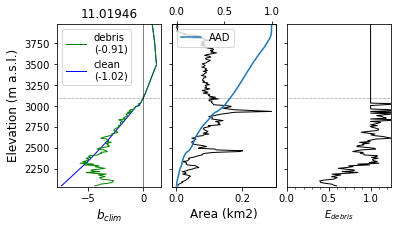

In [6]:
# INDIVIDUAL GLACIER PLOTS
rgiids = ['11.01946']
data_source = 'regional'

for nrgiid, rgiid in enumerate(rgiids):
    print(rgiid)
    
    roi = rgiid.split('.')[0]

    mbclim_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/_noretreat/'
    mbclim_fp_roi = mbclim_fp + data_source + '-mbclim/' + roi + '/'
    mbclim_fn = rgiid + '_mbclim_data.csv'

    mbclim_df = pd.read_csv(mbclim_fp_roi + mbclim_fn)
    
    # Plot regional curves
    # Only plot mass balance of bins with glacier (otherwise get streaks to 0 that aren't real)
    elev_bins = mbclim_df.elev.values
    bins_area = mbclim_df.area.values
    glacier_debrismf = mbclim_df.mf.values
    glac_bin_massbalclim_annual_mean_wdebris = mbclim_df.mbclim_mwea_wdebris.values
    glac_bin_massbalclim_annual_mean_nodebris = mbclim_df.mbclim_mwea_nodebris.values
    
    mbclim_wdebris_4fig = "{:.2f}".format((bins_area * glac_bin_massbalclim_annual_mean_wdebris).sum() 
                                          / bins_area.sum())
    mbclim_nodebris_4fig = "{:.2f}".format((bins_area * glac_bin_massbalclim_annual_mean_nodebris).sum() 
                                           / bins_area.sum())
    print('wdebris:', mbclim_wdebris_4fig, 'nodebris:', mbclim_nodebris_4fig)
    
    bins_idx = np.where(bins_area > 0)[0]
    # ELA for each plot
    ela = elev_bins[np.abs(glac_bin_massbalclim_annual_mean_wdebris[bins_idx]).argmin()]
    
    fig, ax = plt.subplots(1, 3, squeeze=False, sharex=False, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0})

    # Mass balance gradients
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_wdebris[bins_idx], elev_bins[bins_idx], 
                 color='g', linewidth=1, zorder=2, label='debris\n(' + mbclim_wdebris_4fig + ')')
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_nodebris[bins_idx], elev_bins[bins_idx], 
                 color='b', linewidth=1, zorder=1, label='clean\n(' + mbclim_nodebris_4fig + ')')
    ax[0,0].axvline(x=0, color='k', linewidth=0.5)
    ax[0,0].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,0].set_xlabel('$b_{clim}$', size=12)
    ax[0,0].set_ylabel('Elevation (m a.s.l.)', size=12)
    ax[0,0].set_ylim(elev_bins.min() - 10, elev_bins.max() + 10)
    ax[0,0].legend()
    ax[0,0].set_title(rgiid)

    # Glacier hypsometry
    ax[0,1].plot(bins_area[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,1].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,1].set_xlabel('Area (km2)', size=12)
    
    ax2 = ax[0,1].twiny()
    bins_area_cumsum = np.cumsum(bins_area)
    ax2.plot(bins_area_cumsum / bins_area.sum(), elev_bins, label='AAD')
    ax2.legend()

    # Debris thickness
    ax[0,2].plot(glacier_debrismf[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,2].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,2].set_xlabel('$E_{debris}$')
    ax[0,2].set_xlim(0,1.25)
    ax[0,2].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0,2].xaxis.set_minor_locator(plt.MultipleLocator(0.1))

#     # Tick parameters
#     #ax[0,0].yaxis.set_ticks_position('both')
#     ax[0,0].tick_params(axis='both', which='major', labelsize=10, direction='inout')
#     ax[0,0].tick_params(axis='both', which='minor', labelsize=8, direction='in') 
    # Save plot
    fig.set_size_inches(6, 3)
    fig_fp = mbclim_fp + 'debris_figs/' + data_source + '/' + rgiid.split('.')[0] + '/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig_fn = rgiid + '_mbgrad_debris.png'
    fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300, transparent=True)

In [20]:
# Calculate retreat rates
reg_areachg_fn = debris_prms.output_fp + 'reg_areachg_ipcc_table.csv'
reg_areachg_raw = pd.read_csv(reg_areachg_fn)
rois = [1,2,3,4,6,7,8,10,11,13,14,15,16,17,18]

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, variance**0.5

for roi in rois:
    reg_areachg_subset = reg_areachg_raw[reg_areachg_raw['roi'] == roi]
    reg_retreat_rate, reg_retreat_rate_std = weighted_avg_and_std(reg_areachg_subset['Change_%yr'].values, 
                                                                  reg_areachg_subset.area_km2.values)
    
#     ((reg_areachg_subset.area_km2 * reg_areachg_subset['Change_%yr']).sum() / 
#                          reg_areachg_subset.area_km2.sum())
    print(roi, reg_retreat_rate, reg_retreat_rate_std)
    
all_retreat_rate, all_retreat_rate_std = weighted_avg_and_std(reg_areachg_raw['Change_%yr'].values, 
                                                              reg_areachg_raw.area_km2.values)
print('all', all_retreat_rate, all_retreat_rate_std)

1 -0.42 0.0
2 -0.5415170584975857 0.24433485163697843
3 -0.06839557031494482 0.029575013097343162
4 -0.08357149945420264 0.049720327024116204
6 -0.58 0.0
7 -0.26 0.0
8 -0.1787505093032732 0.10784456491354635
10 -0.5237548264952794 0.6732343531846161
11 -0.9308614011957496 0.46698079141219023
13 -0.1781366485737538 0.1714525303655506
14 -0.35699016466214434 0.08075400839448407
15 -0.46756317251422563 0.13341779363359405
16 -1.1901627269674726 0.5406712404653435
17 -0.19782919673360397 0.08153346491996315
18 -0.69 0.0
all -0.1837935196611777 0.23149657136252336


In [ ]:
1 -0.42
2 -0.5415170584975857
3 -0.06839557031494482
4 -0.08357149945420264
6 -0.58
7 -0.26
8 -0.1787505093032732
10 -0.5237548264952794
11 -0.9308614011957496
13 -0.1781366485737538
14 -0.35699016466214434
15 -0.46756317251422563
16 -1.1901627269674726
17 -0.19782919673360397
18 -0.69
all -0.1837935196611777

In [12]:
reg_areachg_raw

,roi,Region,Mtn Range,Start yr,End yr,# years,glac_count,area_km2,relchg_%,Change_%yr,Reference
0,1,"USA, AK",Chugach Mountains,1952,2007,55,347,1285.7,–23,-0.42,Le Bris et al. (2011)
1,2,USA,North Cascades,1958,1998,40,321,117.3,–7.0,-0.18,Granshaw and Fountain (2006)
2,2,Canada,Rocky Mountains,1985,2001,16,523,1056.7,–7.6,-0.48,Tennant et al. (2012)
3,2,NaN,NaN,2001,2006,5,523,976.5,–9.9,-1.98,NaN
4,2,NaN,NaN,1985,2006,21,523,880.0,–16.7,-0.80,NaN
...,...,...,...,...,...,...,...,...,...,...,...
111,17,NaN,NaN,2001,2011,10,165,23229.0,–2.2,-0.22,NaN
112,17,NaN,NaN,1986,2011,25,183,22717.0,–4.3,-0.17,NaN
113,17,Chile,Northern Patagonia Icefield,1979,2001,22,>70b,4093.0,–3.4,-0.15,Rivera et al. (2007)
114,17,Chile,Aconcagua Basin,1955,2003,48,NaN,151.0,–19.9,-0.41,Bown et al. (2008)


1011 glaciers in region 18 are included in this model run: ['00002', '00004', '00009', '00011', '00013', '00019', '00020', '00021', '00024', '00025', '00028', '00029', '00030', '00031', '00032', '00034', '00035', '00036', '00037', '00038', '00040', '00041', '00042', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00054', '00055', '00056', '00057', '00058', '00059', '00062', '00063', '00065', '00066', '00067', '00069', '00070', '00071', '00072', '00073', '00074', '00076'] and more
This study is focusing on 1011 glaciers in region [18]
ROI 18 has 1011 dc glaciers
All glaciers within region(s) 18 are included in this model run.
This study is focusing on 3537 glaciers in region [18]
2526 glaciers in region 18 are included in this model run: ['00001', '00003', '00005', '00006', '00007', '00008', '00010', '00012', '00014', '00015', '00016', '00017', '00018', '00022', '00023', '00026', '00027', '00033', '00039', '00043', '00053', '00060', '00061', '00064', '0

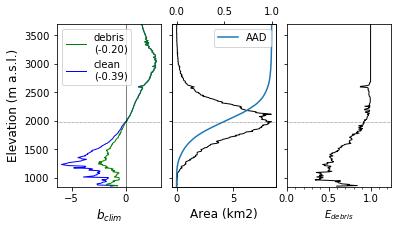

In [7]:
# ===== REGIONAL MBCLIM PLOTS (REMOVING LOWERMOST XX% OF GLACIER AREA) ==========================================
# PyGEM HH2015 calibration with and without debris
reg_output_cns = ['roi', 'area_km2', 'mb_obs_mwea', 'mb_obs_mwea_std', 'mb_mod_mwea', 'mb_mod_mwea_clean']
reg_output_df = pd.DataFrame(np.zeros((len(rois),len(reg_output_cns))), columns=reg_output_cns)
for nroi, roi in enumerate(rois):
    
    output_fp_roi = output_fp + data_source + '-mbclim/' + roi + '/'
    
    mbclim_fns = []
    for i in os.listdir(output_fp_roi):
        if i.endswith('_mbclim_data.csv'):
            mbclim_fns.append(i)
    
    mbclim_fns = sorted(mbclim_fns)
    rgiids_wdebris = ['RGI60-' + x.split('_')[0].split('.')[0].zfill(2) + '.' + x.split('_')[0].split('.')[1] 
                      for x in mbclim_fns]
    rgino_str_wdebris = [x.split('-')[1] for x in rgiids_wdebris]
    
    main_glac_rgi_wdebris = debris_prms.selectglaciersrgitable(glac_no=rgino_str_wdebris)
    main_glac_rgi_wdebris['RefYear'] = (main_glac_rgi_wdebris['RefDate'] / 1e4).astype(int)
    main_glac_rgi_wdebris['mbclim_fn'] = mbclim_fns
    
    print('ROI', roi, 'has', len(rgiids_wdebris), 'dc glaciers')
    
    mbclim_df_all = None
    reg_dc_area = 0
    for nglac, mbclim_fn in enumerate(main_glac_rgi_wdebris.mbclim_fn.values):
        mbclim_df = pd.read_csv(output_fp_roi + main_glac_rgi_wdebris.loc[nglac,'mbclim_fn'])
        mbclim_df['elev'] = [int(np.round(x,0)) for x in mbclim_df.elev.values]
        
        dc_perc_min = area_chg_rate_dict[roi] * (main_glac_rgi_wdebris.loc[nglac,'RefYear'] - 2015)
        
        mbclim_df['area_cumsum_%'] = np.cumsum(mbclim_df.area) / mbclim_df.area.sum() * 100
        mbclim_df = mbclim_df[mbclim_df['area_cumsum_%'] > dc_perc_min].copy()
        mbclim_df.reset_index(inplace=True, drop=True)
        
#         print(mbclim_fn, main_glac_rgi_wdebris.loc[nglac, 'rgino_str'])
#         print('  ', mbclim_df.area.sum(), main_glac_rgi_wdebris.loc[nglac, 'Area'])
        if mbclim_df_all is None:
            mbclim_df_all = mbclim_df
        else:
            mbclim_df_all = pd.concat([mbclim_df_all, mbclim_df], axis=0)
    mbclim_df_all.reset_index(inplace=True, drop=True)
    
    elev_min = mbclim_df_all.elev.min()
    elev_max = mbclim_df_all.elev.max()
    elev_bins_all = np.arange(elev_min, elev_max+5, 10)
    reg_mbclim_cns = ['elev', 'area', 'mf', 'mbclim_mwea_wdebris', 'mbclim_mwea_nodebris', 'frontalablation']
    reg_mbclim_df = pd.DataFrame(np.zeros((len(elev_bins_all), len(reg_mbclim_cns))), columns=reg_mbclim_cns)
    for nelev, elev in enumerate(elev_bins_all):
        try:
            elev_idx = np.where(mbclim_df_all.elev.values == elev)[0]
        except:
            elev_idx = []
        
        if len(elev_idx) > 0:
            mbclim_df_all_subset = mbclim_df_all[mbclim_df_all.elev == elev]
            reg_subset_area = mbclim_df_all_subset.area.sum()
            reg_subset_mf = (mbclim_df_all_subset.mf * mbclim_df_all_subset.area).sum() / reg_subset_area
            reg_subset_mbclim_wdebris = ((mbclim_df_all_subset.mbclim_mwea_wdebris * mbclim_df_all_subset.area).sum() 
                                         / reg_subset_area)
            reg_subset_mbclim_nodebris = ((mbclim_df_all_subset.mbclim_mwea_nodebris * mbclim_df_all_subset.area).sum() 
                                          / reg_subset_area)
            reg_frontalablation = ((mbclim_df_all_subset.frontalablation * mbclim_df_all_subset.area).sum() 
                                   / reg_subset_area)
            reg_mbclim_df.loc[nelev,:] = [elev, reg_subset_area, reg_subset_mf, reg_subset_mbclim_wdebris, 
                                          reg_subset_mbclim_nodebris, reg_frontalablation]
            
    # ===== REGIONAL COMPUTATIONS ======
    reg_mbclim_wdebris_DC = (reg_mbclim_df.mbclim_mwea_wdebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()
    reg_mbclim_nodebris_DC = (reg_mbclim_df.mbclim_mwea_nodebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()

    main_glac_rgi_all = debris_prms.selectglaciersrgitable(rgi_regionsO1=[int(roi)], rgi_regionsO2='all',
                                                           rgi_glac_number='all')
    rgiids_all = list(main_glac_rgi_all.RGIId.values)
    rgiids_missing = set(rgiids_all) - set(rgiids_wdebris)
    rgino_str_missing = [x.split('-')[1] for x in rgiids_missing]
    main_glac_rgi_missing = debris_prms.selectglaciersrgitable(glac_no=rgino_str_missing)
    
    print('Debris-covered area only:')
    print('  mbclim (debris): ' + str(np.round(reg_mbclim_wdebris_DC,2)) + ' mwea')
    print('  mbclim (clean): ' + str(np.round(reg_mbclim_nodebris_DC,2)) + ' mwea')
    print(str(np.round(main_glac_rgi_missing.Area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print(str(np.round(reg_mbclim_df.area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print('reg_mbclim_df area:', reg_mbclim_df.area.sum())
    print('regional area:', main_glac_rgi_all.Area.sum())
    
    reg_mb_all = roi_mbobs_dict[roi][0]
    print(reg_mbclim_wdebris_DC, reg_mbclim_df.area.sum(), reg_mb_all, main_glac_rgi_missing.Area.sum())

    reg_mb_wdebris = ((reg_mbclim_wdebris_DC * reg_mbclim_df.area.sum() + 
                       reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                      / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))
    reg_mb_nodebris = ((reg_mbclim_nodebris_DC * reg_mbclim_df.area.sum() + 
                        reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                       / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))

    print('reg_mb_wdebris:', np.round(reg_mb_wdebris,2))
    print('reg_mb_nodebris:', np.round(reg_mb_nodebris,2))

            
    # ===== Plot regional curves ======
    # Only plot mass balance of bins with glacier (otherwise get streaks to 0 that aren't real)
    elev_bins = reg_mbclim_df.elev.values
    bins_area = reg_mbclim_df.area.values
    glacier_debrismf = reg_mbclim_df.mf.values
    glac_bin_massbalclim_annual_mean_wdebris = reg_mbclim_df.mbclim_mwea_wdebris.values
    glac_bin_massbalclim_annual_mean_nodebris = reg_mbclim_df.mbclim_mwea_nodebris.values
    
    bins_idx = np.where(bins_area > 0)[0]
    # ELA for each plot
    ela = elev_bins[np.abs(glac_bin_massbalclim_annual_mean_wdebris[bins_idx]).argmin()]
    
    fig, ax = plt.subplots(1, 3, squeeze=False, sharex=False, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0})
    
    mbclim_wdebris_4fig = "{:.2f}".format(reg_mb_wdebris)
    mbclim_nodebris_4fig = "{:.2f}".format(reg_mb_nodebris)
    bins_idx = np.where(bins_area > 0)[0]
    # Mass balance gradients
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_wdebris[bins_idx], elev_bins[bins_idx], 
                 color='g', linewidth=1, zorder=2, label='debris\n(' + mbclim_wdebris_4fig + ')')
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_nodebris[bins_idx], elev_bins[bins_idx], 
                 color='b', linewidth=1, zorder=1, label='clean\n(' + mbclim_nodebris_4fig + ')')
    ax[0,0].axvline(x=0, color='k', linewidth=0.5)
    ax[0,0].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,0].set_xlabel('$b_{clim}$', size=12)
    ax[0,0].set_ylabel('Elevation (m a.s.l.)', size=12)
    ax[0,0].set_ylim(elev_bins.min() - 10, elev_bins.max() + 10)
    ax[0,0].legend()

    # Glacier hypsometry
    ax[0,1].plot(bins_area[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,1].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,1].set_xlabel('Area (km2)', size=12)
    
    ax2 = ax[0,1].twiny()
    bins_area_cumsum = np.cumsum(bins_area)
    ax2.plot(bins_area_cumsum / bins_area.sum(), elev_bins, label='AAD')
    ax2.legend()

    # Debris thickness
    ax[0,2].plot(glacier_debrismf[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,2].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,2].set_xlabel('$E_{debris}$')
    ax[0,2].set_xlim(0,1.25)
    ax[0,2].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0,2].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  

#     # Tick parameters
#     #ax[0,0].yaxis.set_ticks_position('both')
#     ax[0,0].tick_params(axis='both', which='major', labelsize=10, direction='inout')
#     ax[0,0].tick_params(axis='both', which='minor', labelsize=8, direction='in') 
    # Save plot
    fig.set_size_inches(6, 3)
    fig_fp = output_fp + 'debris_figs/' + data_source + '/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig_fn = roi + '_mbgrad_debris-REMOVED_RETREAT.png'
    fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300, transparent=True)

In [2]:
print('\n\n\n      ====== FUNCTIONS AND MODEL FOR TWO GRADIENT APPROACH ======\n\n')
# def date_yrfrac_to_yyyymm(date_yrfrac):
#     if int(date_yrfrac)%4 == 0:
#         doy = date_yrfrac%1*366
#     else:
#         doy = date_yrfrac%1*365
#     return datetime.strptime(str(int(date_yrfrac)) + '-' + str(int(doy)),'%Y-%j').date().strftime('%Y-%m')

# def create_datestable(startdate, enddate):
#     """
#     Create table of year, month, day, water year, season and number of days in the month.

#     Parameters
#     ----------
#     startdate, enddate : str
#         start and end data in string format ('YYYY-MM')

#     Returns
#     -------
#     dates_table : pd.DataFrame
#         table where each row is a timestep and each column is attributes (date, year) of that timestep
#     """
#     # Generate dates_table using date_range function
#     # Automatically generate dates from start date to end data using a monthly frequency (MS), which generates
#     # monthly data using the 1st of each month
#     dates_table = pd.DataFrame({'date' : pd.date_range(startdate, enddate, freq='MS')})
#     # Select attributes of DateTimeIndex (dt.year, dt.month, and dt.daysinmonth)
#     dates_table['year'] = dates_table['date'].dt.year
#     dates_table['month'] = dates_table['date'].dt.month
#     dates_table['daysinmonth'] = dates_table['date'].dt.daysinmonth
#     dates_table['timestep'] = np.arange(len(dates_table['date']))
#     # Set date as index
#     dates_table.set_index('timestep', inplace=True)
#     return dates_table


# def annualweightedmean_array(var, dates_table):
#     """ Calculate annual mean of variable according to the timestep """        
#     dayspermonth = dates_table['daysinmonth'].values.reshape(-1,12)
#     #  creates matrix (rows-years, columns-months) of the number of days per month
#     daysperyear = dayspermonth.sum(axis=1)
#     #  creates an array of the days per year (includes leap years)
#     weights = (dayspermonth / daysperyear[:,np.newaxis]).reshape(-1)
#     #  computes weights for each element, then reshapes it from matrix (rows-years, columns-months) to an array, 
#     #  where each column (each monthly timestep) is the weight given to that specific month
#     var_annual = (var*weights[np.newaxis,:]).reshape(-1,12).sum(axis=1).reshape(-1,daysperyear.shape[0])
#     #  computes matrix (rows - bins, columns - year) of weighted average for each year
#     #  explanation: var*weights[np.newaxis,:] multiplies each element by its corresponding weight; .reshape(-1,12) 
#     #    reshapes the matrix to only have 12 columns (1 year), so the size is (rows*cols/12, 12); .sum(axis=1) 
#     #    takes the sum of each year; .reshape(-1,daysperyear.shape[0]) reshapes the matrix back to the proper 
#     #    structure (rows - bins, columns - year)
#     # If averaging a single year, then reshape so it returns a 1d array
#     if var_annual.shape[1] == 1:
#         var_annual = var_annual.reshape(var_annual.shape[0])
#     return var_annual


# def calc_mb_mwea(bin_elev, glacier_gcm_prec, glacier_gcm_temp, glacier_gcm_lr, glacier_gcm_elev, dates_table, 
#                  prec_factor=1, temp_change=0, ddf_ice=0.006, ddf_snow=None):
#     """ Climatic mass balance (accumulation + refreeze - melt) according to PyGEM """
    
#     # Degree-day factor
#     if ddf_snow is not None:
#         ddf = ddf_snow
#     else:
#         ddf = ddf_ice
    
#     # Temperature based on lapse rate
#     bin_gcm_temp = glacier_gcm_temp + glacier_gcm_lr * (bin_elev - glacier_gcm_elev) + temp_change
    
#     # Accumulation
#     bin_snow = prec_factor * glacier_gcm_prec.copy()
#     bin_snow[bin_gcm_temp > debris_prms.Tsnow_threshold] = 0
#     bin_snow[bin_snow < debris_prms.snow_min] = 0
#     bin_acc_mwea = bin_snow.sum() / 12
    
#     # Melt (clean ice)
#     # Monthly temperature superimposed with daily temperature variability
#     # daily temperature variation in each bin for the monthly timestep
#     melt_total = 0
#     np.random.seed(0)
#     for step, dayspermonth in enumerate(dates_table['daysinmonth'].values):
#         bin_tempstd_daily = (np.random.normal(loc=0, scale=glacier_gcm_tempstd[step], size=dayspermonth)
#                              .reshape(1,dayspermonth))
#         # daily temperature in each bin for the monthly timestep
#         bin_temp_daily = bin_gcm_temp[step] + bin_tempstd_daily
#         # remove negative values
#         bin_temp_daily[bin_temp_daily < 0] = 0
#         # Melt
#         melt_month = bin_temp_daily.sum() * ddf_ice
#         melt_total += melt_month
#     bin_melt_mwea = melt_total / 12    
    
#     # Refreeze based on annual air temperature (Woodward etal. 1997)
#     #  R(m) = (-0.69 * Tair + 0.0096) * 1 m / 100 cm
#     if dates_table.shape[0]%12 > 0:
#         dates_table_cropped = dates_table.loc[0:dates_table.shape[0]-1-dates_table.shape[0]%12,:]
#         bin_gcm_temp_cropped = bin_gcm_temp[0:dates_table.shape[0]-dates_table.shape[0]%12]
#     else:
#         dates_table_cropped = dates_table
#         bin_gcm_temp_cropped = bin_gcm_temp
#     bin_temp_annual = annualweightedmean_array(bin_gcm_temp_cropped, dates_table_cropped)
#     bin_refreezepotential_annual = (-0.69 * bin_temp_annual + 0.0096) * 1/100
#     # Remove negative refreezing values
#     bin_refreezepotential_annual[bin_refreezepotential_annual < 0] = 0
#     bin_refreeze_mwea = bin_refreezepotential_annual.mean()
#     if bin_refreeze_mwea > bin_melt_mwea:
#         bin_refreeze_mwea = bin_melt_mwea
        
#     # Mass balance (mwea)
#     bin_mb_mwea = bin_acc_mwea + bin_refreeze_mwea - bin_melt_mwea 
    
#     return bin_mb_mwea


# def calc_mbclim_ela(elev_bins, zmin_mb_mwea, zmax_mb_mwea, z_ela, mf_values):
#     mbclim_grad_mwea = np.zeros(elev_bins.shape)
#     elev_ltzmed_idx = np.where(elev_bins < z_ela)[0]
#     mbclim_grad_mwea[elev_ltzmed_idx] = (
#         -1*zmin_mb_mwea * (elev_bins[elev_ltzmed_idx] - z_ela) / (z_ela - zmin))
#     elev_gtzmed_idx = np.where(elev_bins > z_ela)[0]
#     mbclim_grad_mwea[elev_gtzmed_idx] = zmax_mb_mwea * (elev_bins[elev_gtzmed_idx] - z_ela) / (zmax - z_ela)
#     return mbclim_grad_mwea


# def weighted_percentile(sorted_list, weights, percentile):
#     """
#     Calculate weighted percentile of a sorted list
#     """
#     weights_cumsum_norm_high = np.cumsum(weights) / np.sum(weights)
# #     print(weights_cumsum_norm_high)
#     weights_norm = weights / np.sum(weights)
#     weights_cumsum_norm_low = weights_cumsum_norm_high - weights_norm
# #     print(weights_cumsum_norm_low)
    
#     percentile_idx_high = np.where(weights_cumsum_norm_high >= percentile)[0][0]
# #     print(percentile_idx_high)
#     percentile_idx_low = np.where(weights_cumsum_norm_low <= percentile)[0][-1]
# #     print(percentile_idx_low)
    
#     if percentile_idx_low == percentile_idx_high:
#         value_percentile = sorted_list[percentile_idx_low]
#     else:
#         value_percentile = np.mean([sorted_list[percentile_idx_low], sorted_list[percentile_idx_high]])

#     return value_percentile

In [3]:
# # Degree-day factor of clean ice (m w.e. d-1 degC-1)
# output_fp = debris_prms.output_fp + 'mb_grad_model/'
# if not os.path.exists(output_fp):
#     os.makedirs(output_fp)

# # Glaciers optimized
# overwrite = False
# # rois = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15', '16','17','18']
# # rois = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15', '16','17','18']
# rois = ['05']

# print('need to run region 05')

# data_source = 'regional'
# # data_source = 'individual_glaciers'

# if data_source in ['individual_glaciers']:
#     mb_shean_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/' + 
#                        'hma_mb_20190215_0815_std+mean_all_filled_bolch.csv')
#     mb_shean_df = pd.read_csv(mb_shean_fullfn)
#     mb_shean_df['RGIId'] = ['RGI60-' + str(int(x)) + '.' + str(int(np.round((x - int(x)) * 1e5,0))).zfill(5) 
#                             for x in mb_shean_df.RGIId.values]
# elif data_source in ['regional']:
#     roi_mbobs_dict = {'01': [-0.70, 0.18],
#                       '02': [-0.50, 0.91],
#                       '03': [-0.38, 0.80],
#                       '04': [-0.80, 0.22],
#                       '05': [-0.57, 0.20],
#                       '06': [-0.69, 0.26],
#                       '07': [-0.27, 0.17],
#                       '08': [-0.66, 0.27],
#                       '09': [-0.30, 0.27],
#                       '10': [-0.40, 0.31],
#                       '11': [-0.91, 0.70],
#                       '12': [-0.88, 0.57],
#                       '13': [-0.19, 0.15],
#                       '14': [-0.11, 0.15],
#                       '15': [-0.44, 0.15],
#                       '16': [-0.59, 0.58],
#                       '17': [-0.86, 0.17],
#                       '18': [-0.59, 1.14]}


# reg_output_cns = ['roi', 'area_km2', 'mb_obs_mwea', 'mb_obs_mwea_std', 'mb_mod_mwea', 'mb_mod_mwea_clean']
# reg_output_df = pd.DataFrame(np.zeros((len(rois),len(reg_output_cns))), columns=reg_output_cns)
# for nroi, roi in enumerate(rois):
    
#     output_fn = roi + '_mb_grad_model_opt.csv'
    
#     if overwrite or not os.path.exists(output_fp + output_fn):
    
#         if roi in ['13','14','15']:
#             roi_4dict = 'HMA'
#         else:
#             roi_4dict = roi

#         rgiids = []
#         mb_bin_fns_whd = []
#         mb_bin_fns = []
#         # Filepaths
#         mb_bin_fp = debris_prms.output_fp + 'mb_bins/csv/_wdebris_hdts/'
#         mb_bin_fp_extrap = debris_prms.output_fp + 'mb_bins/csv/_wdebris_hdts_extrap/'
#         mb_bin_fp_all = debris_prms.output_fp + 'mb_bins_all/csv/' + roi_4dict + '/'
#         mb_bin_fp_all_nodhdt = debris_prms.output_fp + 'mb_bins_all/csv/' + roi_4dict + '/no_dhdt/'

#         # Filepaths
#         mb_bin_fp = debris_prms.output_fp + 'mb_bins/csv/_wdebris_hdts/'
#         mb_bin_fp_extrap = debris_prms.output_fp + 'mb_bins/csv/_wdebris_hdts_extrap/'

#         # Glaciers optimized
#         mb_bin_fullfns = []
#         for i in os.listdir(mb_bin_fp):
#             if i.endswith('.csv'):
#                 reg_str = str(int(i.split('.')[0])).zfill(2)
#                 if reg_str == roi:
#                     mb_bin_fns_whd.append(mb_bin_fp + i)
#                     rgiids.append(i.split('_')[0])

#         # Glaciers extrapolated
#         for i in os.listdir(mb_bin_fp_extrap):
#             if i.endswith('_extrap.csv'):
#                 reg_str = str(int(i.split('.')[0])).zfill(2)
#                 if reg_str == roi:
#                     mb_bin_fns_whd.append(mb_bin_fp_extrap + i)
#                     rgiids.append(i.split('_')[0])
                    
        

#         # Sorted files  
#         mb_bin_fns_whd = [x for _,x in sorted(zip(rgiids, mb_bin_fns_whd))]
#         rgiids = sorted(rgiids)     
        
#         rgiids_wdata = []
#         for nrgiid, rgiid in enumerate(rgiids):
#             if roi in ['01','02','03','04','05','06','07','08','09'] and len(rgiid) == 8:
#                 rgiid = rgiid[1:]
#             mb_bin_fn = rgiid + '_mb_bins.csv'
#             mb_bin_fn_nodhdt = rgiid + '_bins.csv'
#             if os.path.exists(mb_bin_fp_all + mb_bin_fn):
#                 mb_bin_fns.append(mb_bin_fp_all + mb_bin_fn)
#                 rgiids_wdata.append(rgiid)
#             elif os.path.exists(mb_bin_fp_all_nodhdt + mb_bin_fn_nodhdt):
#                 mb_bin_fns.append(mb_bin_fp_all_nodhdt + mb_bin_fn_nodhdt)
#                 rgiids_wdata.append(rgiid)
#             else:
#                 print(rgiid)

#         assert len(mb_bin_fns_whd) == len(rgiids_wdata), 'mismatch between mb_bin_fns and rgiids_wdata'
        
#         # ===== LOAD GLACIER DATA =====
#         main_glac_rgi = debris_prms.selectglaciersrgitable(rgiids_wdata)
#         main_glac_rgi['CenLon_360'] = main_glac_rgi['CenLon']
#         main_glac_rgi.loc[main_glac_rgi['CenLon_360'] < 0, 'CenLon_360'] = (
#             360 + main_glac_rgi.loc[main_glac_rgi['CenLon_360'] < 0, 'CenLon_360'])
#         main_glac_rgi['mb_bin_fullfn'] = mb_bin_fns
#         main_glac_rgi['mb_bin_fullfn_whd'] = mb_bin_fns_whd
        
#         # Add mass balance data
#         if data_source in ['individual_glaciers']:
#             shean_rgiid_idx = [i for i, item in enumerate(list(mb_shean_df.RGIId.values)) 
#                                if item in list(main_glac_rgi.RGIId.values)]
#             main_glac_rgi['mb_obs_mwea'] = mb_shean_df.loc[shean_rgiid_idx,'mb_mwea'].values
#             main_glac_rgi['mb_obs_mwea_std'] = mb_shean_df.loc[shean_rgiid_idx,'mb_mwea_sigma'].values
#         elif data_source in ['regional']:
#             main_glac_rgi['mb_obs_mwea'] = roi_mbobs_dict[roi][0]
#             main_glac_rgi['mb_obs_mwea_std'] = roi_mbobs_dict[roi][1]
            
#         # ===== LOAD CLIMATE DATA =====
#         # Dates
#         if data_source in ['individual_glaciers']:
#             start_date = date_yrfrac_to_yyyymm(debris_prms.mb_yrfrac_dict[roi_4dict][0])
#             end_date = date_yrfrac_to_yyyymm(debris_prms.mb_yrfrac_dict[roi_4dict][1])
#             dates_table = create_datestable(start_date, end_date)
#         elif data_source in ['regional']:
#             if roi in ['13','14','15']:
#                 dates_table = create_datestable('2000-06', '2018-05')
#             else:    
#                 dates_table = create_datestable('2006-06', '2015-05')

#         # GCM
#         gcm = class_climate_debris.GCM(name='ERA5')
#         # Air temperature [degC]
#         gcm_temp, gcm_dates = gcm.importGCMvarnearestneighbor_xarray(gcm.temp_fn, gcm.temp_vn, main_glac_rgi,
#                                                                      dates_table)
#         gcm_tempstd, gcm_dates = gcm.importGCMvarnearestneighbor_xarray(gcm.tempstd_fn, gcm.tempstd_vn,
#                                                                         main_glac_rgi, dates_table)
#         # Precipitation [m]
#         gcm_prec, gcm_dates = gcm.importGCMvarnearestneighbor_xarray(gcm.prec_fn, gcm.prec_vn, main_glac_rgi,
#                                                                      dates_table)
#         # Elevation [m asl]
#         gcm_elev = gcm.importGCMfxnearestneighbor_xarray(gcm.elev_fn, gcm.elev_vn, main_glac_rgi)
#         # Lapse rate
#         gcm_lr, gcm_dates = gcm.importGCMvarnearestneighbor_xarray(gcm.lr_fn, gcm.lr_vn, main_glac_rgi, dates_table)
        
        
#         # ===== LOOP THROUGH THE GLACIERS ============================================================================
#         output_cns = ['rgiid', 'area_km2', 'mb_obs_mwea', 'mb_mod_mwea', 'mb_mod_mwea_clean', 'zela', 'zmed', 
#                       'zmin', 'z25', 'z75', 'zmax', 'zmin_mb_mwea', 'zmax_mb_mwea', 'ela_opt_percentile', 'ddfice',
#                       'precfactor', 'tempchange']
#         output_df = pd.DataFrame(np.zeros((main_glac_rgi.shape[0], len(output_cns))), columns=output_cns)

# #     for batman in [0]:
# #         debug = True
# #         for nglac, glac_idx in enumerate(main_glac_rgi.index.values[36:37]):
#         debug = False
#         for nglac, glac_idx in enumerate(main_glac_rgi.index.values): 

#             glac_str = main_glac_rgi.loc[glac_idx,'rgino_str']
#             rgiid = main_glac_rgi.loc[glac_idx,'RGIId']
#             region = glac_str.split('.')[0]

#             if int(region) < 10:
#                 glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
#             else:
#                 glac_str_noleadzero = glac_str

#             if nglac%200 == 0:
# #             if nglac%1 == 0:
#                 print(nglac, glac_str)

#             # Select climate data
#             glacier_gcm_elev = gcm_elev[glac_idx]
#             glacier_gcm_prec = gcm_prec[glac_idx,:]
#             glacier_gcm_temp = gcm_temp[glac_idx,:]
#             glacier_gcm_tempstd = gcm_tempstd[glac_idx,:]
#             glacier_gcm_lr = gcm_lr[glac_idx,:]

#             # Load bins
#             mb_df = pd.read_csv(main_glac_rgi.loc[glac_idx,'mb_bin_fullfn'])
#             mb_df.loc[:,:] = mb_df.values.astype(np.float64)
#             mb_df_whd = pd.read_csv(main_glac_rgi.loc[glac_idx,'mb_bin_fullfn_whd'])
#             mb_df_whd.loc[:,:] = mb_df_whd.values.astype(np.float64)
#             # Weighted melt factor according to debris-covered area in the bin
#             mf_values = mb_df['dc_bin_area_perc']/100 * mb_df_whd['mf_ts_mean'] + (100-mb_df['dc_bin_area_perc'])/100

#             # Min, max, median elevations
#             elev_bins = mb_df.bin_center_elev_m.values
#             area_bins = mb_df.z1_bin_area_valid_km2.values
#             zmin = elev_bins.min()
#             zmax = elev_bins.max()
#             zmed = weighted_percentile(elev_bins, area_bins, 0.5)
#             z25 = weighted_percentile(elev_bins, area_bins, 0.25)
#             z75 = weighted_percentile(elev_bins, area_bins, 0.75)

#             # Calibrate the ELA against the observation
#             mb_obs_mwea = main_glac_rgi.loc[glac_idx, 'mb_obs_mwea']
#             mb_obs_mwea_std = main_glac_rgi.loc[glac_idx, 'mb_obs_mwea_std']

#             if debug:
#                 print('mb_obs:', np.round(mb_obs_mwea,2))
                
#             # Bounds
#             ddfice = 0.006
#             ddfice_step = 0.005
#             ddfice_bndlow, ddfice_bndhigh = 0.0035, 0.009
#             precfactor = 1.5
#             precfactor_step = 0.25
#             precfactor_bndlow, precfactor_bndhigh = 0.8, 2
#             tc = 0
#             tc_step = 0.05
#             tc_bndlow, tc_bndhigh = -10, 10
#             # Boundaries and steps
#             zstep = 10
#             dif_mb_mwea_threshold = 0.01
#             zlimit_lower = z25
#             if zlimit_lower == zmin:
#                 zlimit_lower = zmin + 10
#             continue_while_loop = True
#             nround = 0
#             dif_mb_mwea = 1e6
#             abs_dif_mb_mwea_opt = 1e6
#             ela_perc_thresholds = [40, 85]
#             while continue_while_loop:
# #                 if debug:
# #                     print('\nRound', nround)
#                 # Maximum accumulation (mwea)
#                 ddfsnow = ddfice / 1.5
#                 zmax_mb_mwea = calc_mb_mwea(zmax, glacier_gcm_prec, glacier_gcm_temp, glacier_gcm_lr, 
#                                             glacier_gcm_elev, dates_table, prec_factor=precfactor, 
#                                             temp_change=tc, ddf_snow=ddfsnow)
            
#                 # Maximum melt (mwea)
#                 zmin_mb_mwea = calc_mb_mwea(zmin, glacier_gcm_prec, glacier_gcm_temp, glacier_gcm_lr, 
#                                             glacier_gcm_elev, dates_table, prec_factor=precfactor, 
#                                             temp_change=tc, ddf_ice=ddfice)
    
#                 if debug:
#                     print('zmax mb:', np.round(zmax_mb_mwea,2), 'zmin_mb:', np.round(zmin_mb_mwea,2))
                
#                 # Calibrate ELA
#                 if nround == 0:
#                     z_list = list(np.arange(zlimit_lower, zmax+zstep/2, zstep))
#                 for z_ela in z_list:
#                     # Mass balance gradient model
#                     mbclim_grad_mwea = calc_mbclim_ela(elev_bins, zmin_mb_mwea, zmax_mb_mwea, z_ela, mf_values)
#                     mbclim_grad_mwea_wmf = mbclim_grad_mwea * mf_values

#                     # Glacier-wide mass balance
#                     glac_mb_mwea = (mbclim_grad_mwea_wmf * area_bins).sum() / area_bins.sum()
#                     glac_mb_mwea_clean = (mbclim_grad_mwea * area_bins).sum() / area_bins.sum()
#                     dif_mb_mwea = glac_mb_mwea - mb_obs_mwea

                    
#                     if nround > 0 and debug:
#                         print('z_ela:', z_ela, 'prms:', ddfice, precfactor, tc, 
#                               'mb opt/mod/obs/dif:', np.round(glac_mb_mwea_opt,2), np.round(glac_mb_mwea,2), 
#                               np.round(mb_obs_mwea,2), np.round(dif_mb_mwea,2))
                
# #                 continue_while_loop = False

#                     # Get best value
#                     if abs(dif_mb_mwea) < abs_dif_mb_mwea_opt:
#                         z_ela_opt = z_ela
#                         ddfice_opt = ddfice
#                         pf_opt = precfactor
#                         tc_opt = tc
#                         glac_mb_mwea_opt = glac_mb_mwea
#                         glac_mb_mwea_clean_opt = glac_mb_mwea_clean
#                         dif_mb_mwea_opt = dif_mb_mwea
#                         abs_dif_mb_mwea_opt = abs(dif_mb_mwea)
                        

#                     # If jump over the best value, then stop optimization and go with the minimum
#                     if -1*np.sign(dif_mb_mwea_opt) == np.sign(dif_mb_mwea):
#                         continue_while_loop = False

#                 # Get upper and lower limits
#                 if nround == 0:
#                     if z_ela_opt < zmed:
#                         z_list = list(np.arange(z25, zmed+zstep/2, zstep))
#                     else:
#                         z_list = list(np.arange(zmed, zmax+zstep/2, zstep))
                    
#     #             if debug:
#     #                 print('\n',z_ela_opt, ddfice, precfactor, tc, glac_mb_mwea_opt, mb_obs_mwea, abs_dif_mb_mwea_opt)

#                 # ELA percentile
#                 lt_ela_idx = np.where(elev_bins <= z_ela_opt)[0]
#                 ela_opt_percentile = area_bins[lt_ela_idx].sum() / area_bins.sum() * 100
    
#                 # If optimized, then done
#                 if (abs(dif_mb_mwea_opt) <= dif_mb_mwea_threshold and 
#                     (ela_opt_percentile < ela_perc_thresholds[0] or ela_opt_percentile > ela_perc_thresholds[1])):
#                     continue_while_loop = False
#                 # Otherwise, iterate through various ddfice, precfactors, tempchange
#                 else:
#                     if dif_mb_mwea_opt > 0:
#                         # PyGEM initial calibration
#                         # Decrease kp, increase Tbias
#                         precfactor = precfactor - precfactor_step
#                         if precfactor < precfactor_bndlow:
#                             precfactor = precfactor_bndlow
#                             ddfice = ddfice + ddfice_step
#                             if ddfice > ddfice_bndhigh:
#                                 ddfice = ddfice_bndhigh
#                                 tc = tc + tc_step
                        
#                         # Initial method
# #                         ddfice = ddfice + ddfice_step
# #                         if ddfice >= ddfice_bndhigh:
# #                             ddfice = ddfice_bndhigh
# #                             precfactor = precfactor - precfactor_step
# #                             if precfactor <= precfactor_bndlow:
# #                                 precfactor = precfactor_bndlow
# #                                 tc = tc + tc_step
#                     elif dif_mb_mwea_opt < 0:
#                         precfactor = precfactor + precfactor_step
#                         if precfactor > precfactor_bndhigh:
#                             precfactor = precfactor_bndhigh
#                             ddfice = ddfice - ddfice_step
#                             if ddfice < ddfice_bndlow:
#                                 ddfice = ddfice_bndlow
#                                 tc = tc - tc_step
# #                         ddfice = ddfice - ddfice_step
# #                         if ddfice <= ddfice_bndlow:
# #                             ddfice = ddfice_bndlow
# #                             precfactor = precfactor + precfactor_step
# #                             if precfactor >= precfactor_bndhigh:
# #                                 precfactor = precfactor_bndhigh
# #                                 tc = tc - tc_step

#                     if precfactor > precfactor_bndhigh:
#                         precfactor = precfactor_bndhigh
#                     if precfactor < precfactor_bndlow:
#                         precfactor = precfactor_bndlow
#                     if tc > tc_bndhigh:
#                         tc = tc_bndhigh
#                         print(nglac, glac_str, 'HERE - hit upper bound')
#                         continue_while_loop = False
#                     if tc < tc_bndlow:
#                         tc = tc_bndlow
#                         print(nglac, glac_str, 'HERE - hit lower bound')
#                         continue_while_loop = False

#                 nround += 1

#             if debug:
#                 print('\n',z_ela_opt, ddfice_opt, pf_opt, tc_opt, glac_mb_mwea_opt)

            
#             if debug:
#                 print('  mb_obs (mwea):', np.round(mb_obs_mwea,2), '+/-', np.round(mb_obs_mwea_std,2))
#                 print('  z_ela opt:', np.round(z_ela_opt), '(' + str(np.round(ela_opt_percentile,2)) + '%)', 
#                       'z25, zmed, z75:', z25, zmed, z75)
#                 print('  mb_mod (mwea):', np.round(glac_mb_mwea_opt,2), 'mb_mod (clean):', 
#                       np.round(glac_mb_mwea_clean_opt,2))
            
            
#             if dif_mb_mwea_opt > mb_obs_mwea_std:
#                 print('  ' + glac_str + ' BAD FIT')
#                 error_fp = output_fp + 'errors/poor_fit/' + roi + '/'
#                 if not os.path.exists(error_fp):
#                     os.makedirs(error_fp)
#                 with open(error_fp + glac_str + "-difference_gt_zempstd.txt", "w") as text_file:
#                     text_file.write(glac_str + ' modeled mass balance difference off by more than zempstd')
#             if z_ela_opt == z25:
# #                 print('  ' + glac_str + ' HAS ISSUE - z25')
#                 error_fp = output_fp + 'errors/z25/' + roi + '/'
#                 if not os.path.exists(error_fp):
#                     os.makedirs(error_fp)
#                 with open(error_fp + glac_str + "-poor_mbgrad_model-z25.txt", "w") as text_file:
#                     text_file.write(glac_str + ' bad fit for mb grad model; z_ela_opt equals z25')
#             if z_ela_opt == zmax:
# #                 print('  ' + glac_str + ' HAS ISSUE - zmax')
#                 error_fp = output_fp + 'errors/zmax/' + roi + '/'
#                 if not os.path.exists(error_fp):
#                     os.makedirs(error_fp)
#                 with open(error_fp + glac_str + "-poor_mbgrad_model-zmax.txt", "w") as text_file:
#                     text_file.write(glac_str + ' bad fit for mb grad model; z_ela_opt equals zmax')

#             output_df.loc[glac_idx,:] = [glac_str, area_bins.sum(), mb_obs_mwea, glac_mb_mwea_opt, 
#                                          glac_mb_mwea_clean_opt, z_ela_opt, zmed, zmin, z25, z75, zmax, 
#                                          zmin_mb_mwea, zmax_mb_mwea, ela_opt_percentile, ddfice, precfactor, tc]
#         output_df.to_csv(output_fp + output_fn, index=False)

#     else:
#         output_df = pd.read_csv(output_fp + output_fn)
    
#     # Ensure RGIIds are correctly formatted
#     output_df['rgiid'] = ['RGI60-' + str(x).split('.')[0].zfill(2) + '.' + 
#                           str(int(np.round((np.float(x) - int(np.float(x))) * 1e5,0))).zfill(5) 
#                           for x in output_df.rgiid.values]

#     main_glac_rgi_all = debris_prms.selectglaciersrgitable(rgi_regionsO1=[roi], rgi_regionsO2='all',
#                                                            rgi_glac_number='all')
    
#     # Add the observations for the glaciers not modeled
#     if data_source in ['individual_glaciers']:
#         # Calculate the change in specific mass balance over the region
#         mb_shean_df['roi'] = [x.split('-')[1].split('.')[0] for x in mb_shean_df.RGIId.values]
#         mb_shean_df_roi = mb_shean_df[mb_shean_df.roi == roi]
#         mb_shean_df_roi.reset_index(inplace=True, drop=True)
#         reg_mb_obs_mwea = (mb_shean_df_roi.mb_mwea * mb_shean_df_roi.area_m2).sum() / mb_shean_df_roi.area_m2.sum()
#         reg_mb_obs_mwea_std = 0.15
        
#         # Dictionary of glacier-wide mass balance for every glacier
#         mb_mwea_debris_dict = dict(zip(mb_shean_df.RGIId.values, mb_shean_df.mb_mwea.values))
#         mb_mwea_clean_dict = dict(zip(mb_shean_df.RGIId.values, mb_shean_df.mb_mwea.values))

#     elif data_source in ['regional']:
#         reg_mb_obs_mwea = roi_mbobs_dict[roi][0]
#         reg_mb_obs_mwea_std = roi_mbobs_dict[roi][1]
#         main_glac_rgi_all['mb_obs'] = reg_mb_obs_mwea
#         mb_mwea_debris_dict = dict(zip(main_glac_rgi_all.RGIId.values, main_glac_rgi_all.mb_obs.values))
#         mb_mwea_clean_dict = dict(zip(main_glac_rgi_all.RGIId.values, main_glac_rgi_all.mb_obs.values))
        
#     # Update dictionaries for modeled debris-covered glaciers
#     mb_mwea_debris_dict_output = dict(zip(output_df.rgiid.values, output_df.mb_mod_mwea.values))
#     mb_mwea_clean_dict_output = dict(zip(output_df.rgiid.values, output_df.mb_mod_mwea_clean.values))
    
#     mb_mwea_debris_dict.update(mb_mwea_debris_dict_output)
#     mb_mwea_clean_dict.update(mb_mwea_clean_dict_output)
    
#     main_glac_rgi_all['mb_mwea'] = main_glac_rgi_all.RGIId.map(mb_mwea_debris_dict)
#     main_glac_rgi_all['mb_mwea_clean'] = main_glac_rgi_all.RGIId.map(mb_mwea_clean_dict)

#     reg_mb_mwea_wdebris = (main_glac_rgi_all.Area * main_glac_rgi_all.mb_mwea).sum() / main_glac_rgi_all.Area.sum()
#     reg_mb_mwea_nodebris = ((main_glac_rgi_all.Area * main_glac_rgi_all.mb_mwea_clean).sum() / 
#                             main_glac_rgi_all.Area.sum())

#     assert np.abs(reg_mb_mwea_wdebris - reg_mb_obs_mwea) < reg_mb_obs_mwea_std, 'Reg mass balance outside uncertainty'

#     print('\nreg mb obs (mwea):', np.round(reg_mb_obs_mwea,2))
#     print('reg mb mod (mwea), debris:', np.round(reg_mb_mwea_wdebris,2), 'vs clean:', np.round(reg_mb_mwea_nodebris,2),'\n')
#     reg_output_df.loc[nroi,:] = [roi, main_glac_rgi_all.Area.sum(), reg_mb_obs_mwea, reg_mb_obs_mwea_std, 
#                                  reg_mb_mwea_wdebris, reg_mb_mwea_nodebris]
    
# # # Export regional data
# # all_area = reg_output_df.area_km2.sum()
# # all_zemp_mean = (reg_output_df.area_km2 * reg_output_df.zemp_mean).sum() / reg_output_df.area_km2.sum()
# # all_zemp_std = 0.20
# # all_mb_mwea = (reg_output_df.area_km2 * reg_output_df.mb_mwea).sum() / reg_output_df.area_km2.sum()
# # all_mb_mwea_clean = (reg_output_df.area_km2 * reg_output_df.mb_mwea_clean).sum() / reg_output_df.area_km2.sum()

# # all_df = pd.DataFrame(np.zeros((1,len(reg_output_cns))), columns=reg_output_cns)
# # all_df.loc[0,:] = ['all', all_area, all_zemp_mean, all_zemp_std, all_mb_mwea, all_mb_mwea_clean]

# # all_output_df = pd.concat([reg_output_df, all_df], axis=0)
# # all_output_df['mb_clean_dif'] = all_output_df.mb_mwea - all_output_df.mb_mwea_clean
# # all_output_df_fn = 'reg_mbgrad_impact.csv'
# # all_output_df.to_csv(output_fp + all_output_df_fn, index=False)


need to run region 05
4921 glaciers in region 5 are included in this model run: ['00024', '00035', '00046', '00056', '00058', '00062', '00066', '00068', '00076', '00086', '00096', '00099', '00101', '00102', '00105', '00108', '00109', '00115', '00117', '00120', '00121', '00122', '00124', '00126', '00129', '00139', '00143', '00151', '00154', '00156', '00157', '00161', '00164', '00168', '00169', '00181', '00184', '00188', '00191', '00196', '00200', '00202', '00207', '00210', '00211', '00217', '00222', '00226', '00244', '00247'] and more
This study is focusing on 4921 glaciers in region [5]
0 05.00024
200 05.00790
400 05.01703
600 05.02918
800 05.04096
1000 05.04884
1200 05.06222
1400 05.07132
1600 05.07854
  05.08048 BAD FIT
1800 05.08367
2000 05.08835
  05.09046 BAD FIT
2200 05.09683
2400 05.10003
2600 05.10297
2800 05.10590
3000 05.11466
  05.11856 BAD FIT
3200 05.11916
3400 05.12525
3600 05.13279
3800 05.13947
4000 05.15090
4200 05.16081
4400 05.17486
4600 05.19098
4800 05.19837
All gl

In [5]:
# np.where(main_glac_rgi.rgino_str == '15.00058')

In [5]:
# # Glaciers optimized
# rois = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15', '16','17','18']
# # rois = ['13','14','15']

# for nroi, roi in enumerate(rois):
    
#     output_fn = roi + '_mb_grad_model_opt.csv'
#     output_df = pd.read_csv(output_fp + output_fn)
#     output_df['rgiid'] = [str(x).split('.')[0].zfill(2) + '.' + str(x).split('.')[1] 
#                           for x in output_df.rgiid.values]
    
#     # ===== HISTOGRAM: ELA ======
#     ax = output_df['ela_opt_percentile'].plot.hist(bins=20, alpha=0.5)
#     fig = ax.get_figure()
#     hist_fp = output_fp + 'hist/'
#     if not os.path.exists(hist_fp):
#         os.makedirs(hist_fp)
#     fig.savefig(hist_fp + roi + '_ela_opt_percentile_hist.png')
#     fig.clf()

<Figure size 432x288 with 0 Axes>